In [1]:
import numpy as np
from skimage import io
import glob
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import matplotlib.pyplot as plt
#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import accuracy_score

In [2]:
from skimage import io,transform
import glob
imlist=[]
ylabel=[]
for filename in glob.glob("/content/drive/MyDrive/ANN/Datasets/IndoorOutdoorimageclassification/indoor/indoor/*.jpg"):
    im = io.imread(filename)
    img=tf.cast(im, tf.float32)
    resized_images=tf.image.resize(img, (128, 128))
    imlist.append(resized_images)
    ylabel.append(0)
for filename in glob.glob("/content/drive/MyDrive/ANN/Datasets/IndoorOutdoorimageclassification/outdoor/outdoor/*.jpg"):
    im = io.imread(filename)
    img=tf.cast(im, tf.float32)
    resized_images=tf.image.resize(img, (128, 128))
    imlist.append(resized_images)
    ylabel.append(1)


In [3]:
imlist=np.array(imlist)
imlist /= 255
ylabel=np.array(ylabel)
print(imlist.shape)
print(ylabel.shape)

(799, 128, 128, 3)
(799,)


In [4]:
np.random.seed(seed=0)
train_ind = np.random.randint(low = 0, high = ylabel.size, size = int(0.7*ylabel.size))
train_data = imlist[train_ind]
train_label = ylabel[train_ind]
imlist = np.delete(imlist, train_ind, axis=0)
ylabel = np.delete(ylabel, train_ind, axis=0)
test_ind = np.random.randint(low = 0, high = ylabel.size, size = int((1/3)*ylabel.size))
test_data = imlist[test_ind]
test_label = ylabel[test_ind]
val_data = np.delete(imlist, test_ind, axis=0)
val_label = np.delete(ylabel, test_ind)
print(train_data.shape,train_label.shape)
print(val_data.shape, val_label.shape)
print(test_data.shape, test_label.shape)
print(train_data[0].shape)
print(val_data[0].shape)
print(test_data[0].shape)

(559, 128, 128, 3) (559,)
(279, 128, 128, 3) (279,)
(131, 128, 128, 3) (131,)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)


In [5]:
tf.keras.backend.clear_session()

In [6]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
  def __init__(self, patience=0):
    super(EarlyStoppingCallback, self).__init__()
    self.patience = patience

  def on_train_begin(self, logs=None):
    self.best = -np.Inf
    self.wait = 0
    self.stopped_epoch = 0

  def on_epoch_end(self, epoch, logs=None):
    current_accuracy = logs.get("val_accuracy")
    if np.greater(current_accuracy, self.best):
      self.best = current_accuracy
      self.wait = 0
      self.best_weights = self.model.get_weights()
    else:
      self.wait += 1
      if self.wait >= self.patience:
        self.stopped_epoch = epoch
        self.model.stop_training = True
        self.model.set_weights(self.best_weights)

  def on_train_end(self, logs=None):
    if self.stopped_epoch > 0:
      print("epoch: %d: early stopping" % self.stopped_epoch)

In [7]:
base_model = tf.keras.applications.ResNet101(weights = 'imagenet', include_top = False, input_shape = (128,128,3))

In [8]:
base_model.trainable = False

In [9]:
cls_callback = EarlyStoppingCallback(patience=5)

In [10]:
x = tf.keras.layers.Flatten()(base_model.output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
predictions = tf.keras.layers.Dense(2, activation = 'softmax')(x)

In [11]:
head_model = tf.keras.Model(inputs = base_model.input, outputs = predictions)
head_model.compile(optimizer='adam', loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [12]:
history = head_model.fit(train_data, train_label, batch_size=64, epochs=40, validation_data=(val_data, val_label), callbacks=cls_callback)

Epoch 1/40
9/9 [==============================] - 12s 533ms/step - loss: 1.2288 - accuracy: 0.5564 - val_loss: 0.8444 - val_accuracy: 0.4982
Epoch 2/40
9/9 [==============================] - 1s 174ms/step - loss: 0.7349 - accuracy: 0.5707 - val_loss: 0.7023 - val_accuracy: 0.5197
Epoch 3/40
9/9 [==============================] - 2s 192ms/step - loss: 0.6033 - accuracy: 0.6565 - val_loss: 0.5979 - val_accuracy: 0.7061
Epoch 4/40
9/9 [==============================] - 2s 176ms/step - loss: 0.5117 - accuracy: 0.7496 - val_loss: 0.5924 - val_accuracy: 0.7527
Epoch 5/40
9/9 [==============================] - 1s 173ms/step - loss: 0.4937 - accuracy: 0.7764 - val_loss: 0.5703 - val_accuracy: 0.6989
Epoch 6/40
9/9 [==============================] - 2s 176ms/step - loss: 0.4734 - accuracy: 0.7818 - val_loss: 0.5753 - val_accuracy: 0.6846
Epoch 7/40
9/9 [==============================] - 2s 175ms/step - loss: 0.4451 - accuracy: 0.8050 - val_loss: 0.6067 - val_accuracy: 0.7133
Epoch 8/40
9/9 [===

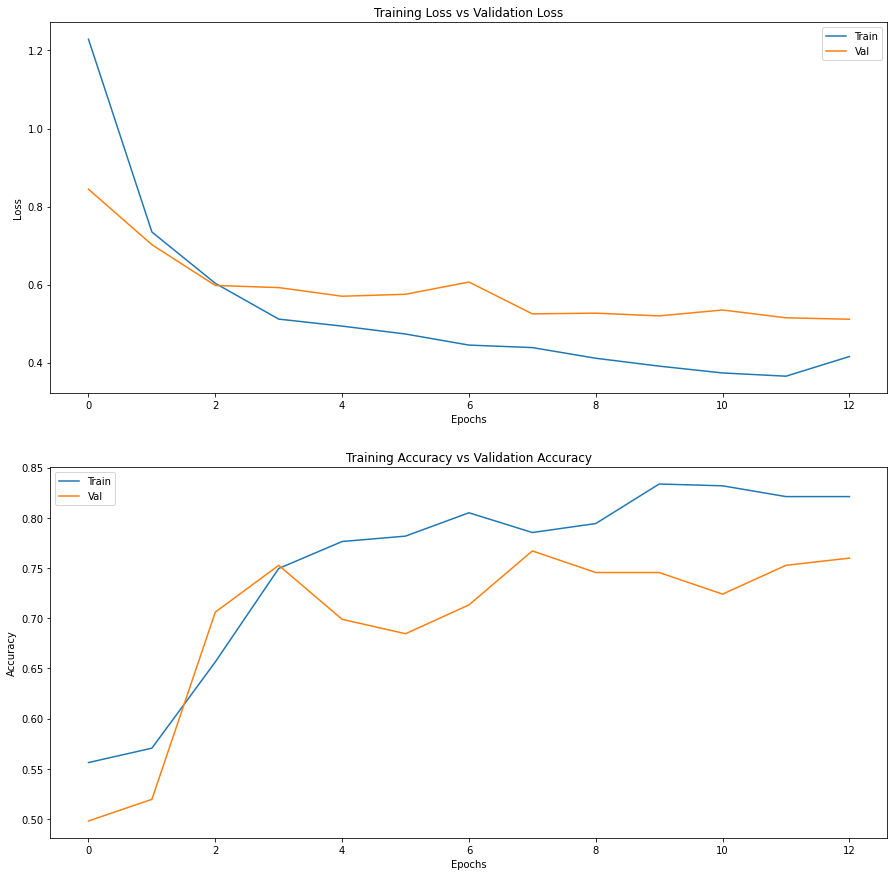

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [14]:
head_model.evaluate(test_data, test_label)

5/5 [==============================] - 1s 135ms/step - loss: 0.4988 - accuracy: 0.7863


[0.49884214997291565, 0.7862595319747925]

In [15]:
test_pred = np.argmax(head_model.predict(test_data), axis=-1)
confmat = tf.math.confusion_matrix(test_label, test_pred)
print(confmat)

tf.Tensor(
[[60 10]
 [18 43]], shape=(2, 2), dtype=int32)


In [16]:
for layer in base_model.layers[-7:]:
  layer.trainable = True

In [17]:
head_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [18]:
head_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
history = head_model.fit(train_data, train_label, batch_size=64, epochs=40, validation_data=(val_data, val_label), callbacks=cls_callback)

Epoch 1/40
9/9 [==============================] - 10s 387ms/step - loss: 0.6338 - accuracy: 0.7657 - val_loss: 0.5217 - val_accuracy: 0.7491
Epoch 2/40
9/9 [==============================] - 2s 181ms/step - loss: 0.5561 - accuracy: 0.7800 - val_loss: 0.5223 - val_accuracy: 0.7491
Epoch 3/40
9/9 [==============================] - 2s 185ms/step - loss: 0.5083 - accuracy: 0.8050 - val_loss: 0.5259 - val_accuracy: 0.7455
Epoch 4/40
9/9 [==============================] - 2s 185ms/step - loss: 0.4390 - accuracy: 0.8211 - val_loss: 0.5309 - val_accuracy: 0.7419
Epoch 5/40
9/9 [==============================] - 2s 185ms/step - loss: 0.4464 - accuracy: 0.8140 - val_loss: 0.5359 - val_accuracy: 0.7348
Epoch 6/40
9/9 [==============================] - 2s 185ms/step - loss: 0.4468 - accuracy: 0.8122 - val_loss: 0.5406 - val_accuracy: 0.7348
epoch: 5: early stopping


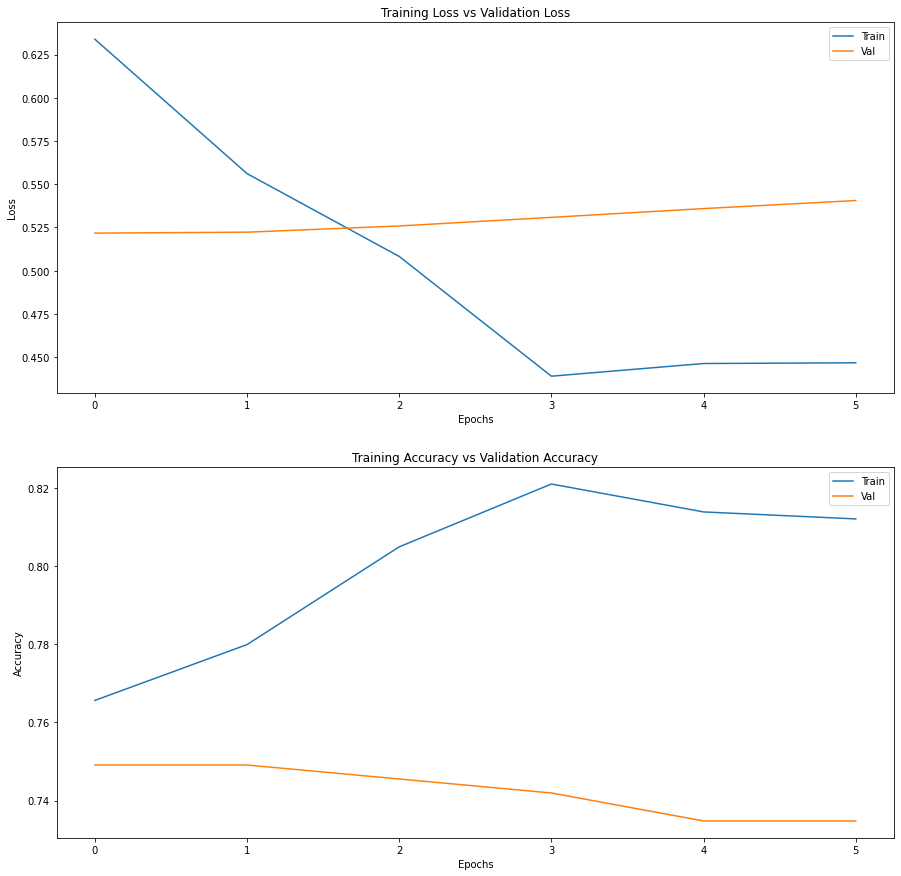

In [19]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [20]:
head_model.evaluate(test_data, test_label)

5/5 [==============================] - 0s 68ms/step - loss: 0.4981 - accuracy: 0.7710


[0.49805980920791626, 0.7709923386573792]

In [21]:
test_pred = np.argmax(head_model.predict(test_data), axis=-1)
confmat = tf.math.confusion_matrix(test_label, test_pred)
print(confmat)

tf.Tensor(
[[58 12]
 [18 43]], shape=(2, 2), dtype=int32)
